In [1]:
import sys
sys.path.insert(0, '../../../PyPlr')

import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context('paper', font_scale=1.2)

from pyplr.CIE import get_CIES026
from pyplr.oceanops import predict_dark_counts, calibrated_radiance

# Spectral sensitivities 

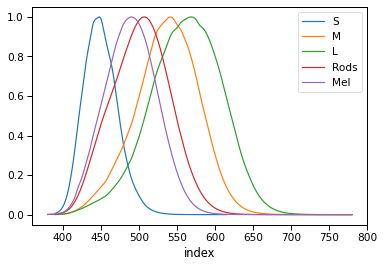

In [2]:
_ , sss = get_CIES026(asdf=True)
#sss = sss[::5] # downsample to 5nm bins
sss.plot()
sss = sss.fillna(0)

# OceanOptics spectrometer data

In [11]:
# Load data
oo_spectra      = pd.read_csv('../data/oo_spectra_11-25-20-15-32.csv', index_col=['led','intensity'])
oo_info         = pd.read_csv('../data/oo_info_11-25-20-15-32.csv', index_col=['led','intensity'])
cal_per_wl      = pd.read_csv('../data/oo_calibration.csv', header=None)
sensor_area_cm2 = pd.read_csv('../data/oo_sensorArea.csv', header=None)

# Predict dark counts and get calibrated radiance
oo_spectra.reset_index(inplace=True, drop=True)
oo_info.reset_index(inplace=True)
oo_dark_counts = predict_dark_counts(oo_info, '../data/oo_dark_cal.txt')
wperm2pernm    = calibrated_radiance(oo_spectra, oo_info, oo_dark_counts, cal_per_wl, sensor_area_cm2)

# Mung
wperm2pernm['led'] = oo_info['led']
wperm2pernm['intensity'] = oo_info['intensity']
wperm2pernm.set_index(['led', 'intensity'], inplace=True)
wperm2pernm.sort_index(inplace=True)
wperm2pernm.columns = sss.index

# Get alphaopic radiance and save
wperm2pernm = wperm2pernm.fillna(0)
oo_aor = wperm2pernm.dot(sss)
oo_aor.to_csv('../data/stlab_oo_alphaopic.csv')
wperm2pernm.to_csv('../data/corrected_oo_spectra.csv')

# STLAB spectrometer data

In [13]:
# Gather some data
stlab_spectra = pd.read_csv('../data/stlab_spectra_11-25-20-15-32.csv')
stlab_info    = pd.read_csv('../data/stlab_info_11-25-20-15-32.csv')

# Mung
stlab_spectra['led'] = stlab_info['led']
stlab_spectra['intensity'] = stlab_info['intensity']
stlab_spectra.set_index(['led', 'intensity'], inplace=True)
stlab_spectra.sort_index(inplace=True)
stlab_spectra.columns = sss.index[::5]

# Get alphaopic radiance and save
stlab_aor = stlab_spectra.dot(sss[::5])
stlab_aor.to_csv('../data/stlab_alphaopic.csv')

In [14]:
stlab_aor

S           M            L        Rods         Mel
led intensity                                                             
0   0            3.922664   11.442876    14.220272   11.639717   10.732604
    65          77.264813    9.975901     9.296741   25.287056   30.870492
    130        231.958355   27.715559    24.675043   73.359920   90.466682
    195        385.948910   37.607859    28.778592  114.915163  143.589376
    260        830.765537   78.103493    58.883606  248.109479  310.631738
...                   ...         ...          ...         ...         ...
9   3835         0.651769  220.902605  1940.932227   15.454945    3.965610
    3900         0.051801  246.105956  2070.448607   19.797366    4.977704
    3965         2.467117  234.080287  2024.732727   17.109333    5.305178
    4030         5.006096  263.769583  2168.724559   20.734082    6.389666
    4095         1.541388  239.060374  2036.463318   20.300158    6.620648

[640 rows x 5 columns]

In [15]:
oo_aor

S             M         L          Rods  \
led intensity                                                       
0   0          5.538015e-12  2.601015e-07  0.000001  2.015171e-08   
    65         3.926633e-02  2.964132e-03  0.002132  1.047563e-02   
    130        1.219449e-01  9.664109e-03  0.007122  3.322591e-02   
    195        2.363641e-01  2.187114e-02  0.017667  6.688924e-02   
    260        4.576713e-01  4.615385e-02  0.038613  1.330243e-01   
...                     ...           ...       ...           ...   
9   3835       1.332050e-01  3.391330e-01  1.748412  1.800606e-01   
    3900       1.300462e-01  3.408393e-01  1.789960  1.756021e-01   
    3965       1.364746e-01  3.480961e-01  1.800813  1.837118e-01   
    4030       1.461056e-01  3.605481e-01  1.823965  1.965392e-01   
    4095       1.454897e-01  3.612782e-01  1.827026  1.964357e-01   

                        Mel  
led intensity                
0   0          2.654358e-09  
    65         1.337104e-02  
    130        4.230922e-02  
    195        8.413657e-02  
    260        1.660500e-01  
...                     ...  
9   3835       1.643927e-01  
    3900       1.597703e-01  
    3965       1.675376e-01  
    4030       1.801088e-01  
    4095       1.796925e-01  

[640 rows x 5 columns]

Text(0.5, 1.0, 'Ocean Optics STS')

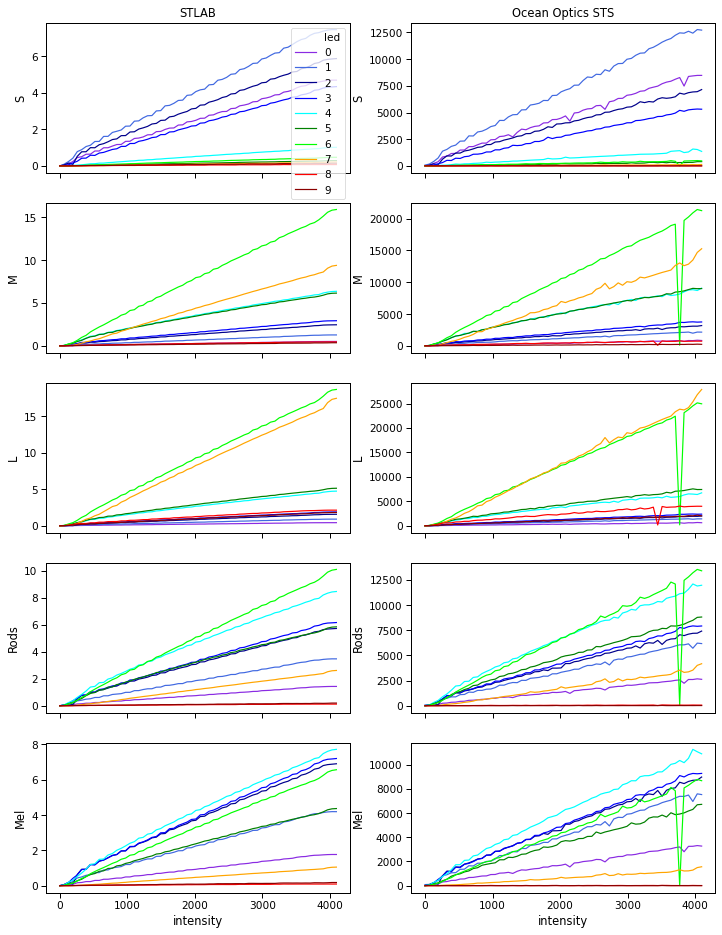

In [17]:
oo_aor.reset_index(inplace=True)
stlab_aor.reset_index(inplace=True)
colors = ['blueviolet', 'royalblue', 'darkblue', 'blue', 'cyan', 
          'green', 'lime', 'orange', 'red', 'darkred']
fig, axs = plt.subplots(5, 2, figsize=(12,16), sharex=True)
axs = [ax for sublist in axs for ax in sublist]

for i, pr in enumerate(['S', 'M', 'L', 'Rods', 'Mel']):
    sns.lineplot(data=oo_aor,    x='intensity', y=pr,    hue='led', palette=colors, ax=axs[i*2])
    sns.lineplot(data=stlab_aor, x='intensity', y=pr,    hue='led', palette=colors, ax=axs[i*2+1])

for ax in axs[1:]:
    ax.get_legend().remove()
axs[0].set_title('STLAB')
axs[1].set_title('Ocean Optics STS')


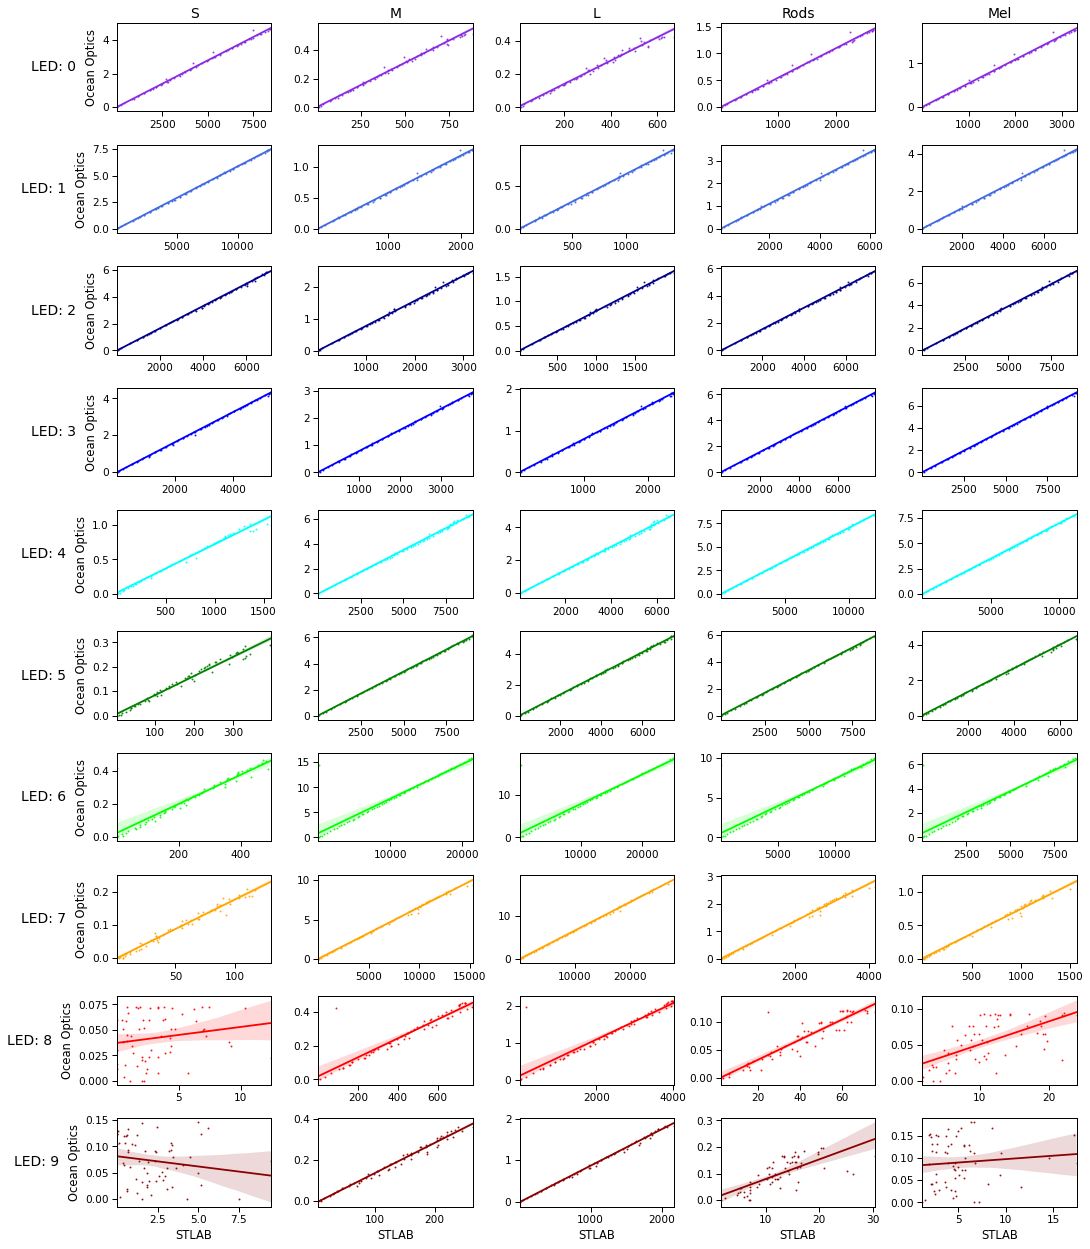

In [19]:
stlab_aor.set_index(['led'], inplace=True)
oo_aor.set_index(['led'], inplace=True)

fig, axs = plt.subplots(10, 5, figsize=(16,18))
plt.setp(axs.flat, xlabel='STLAB', ylabel='OO')

cols = ['{}'.format(col) for col in ['S','M','L','Rods','Mel']]
rows = ['LED: {}'.format(row) for row in range(10)]

pad = 5 # in points

for ax, col in zip(axs[0], cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

for ax, row in zip(axs[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')
axs = [ax for sublist in axs for ax in sublist]
i=0
for led in range(10):
    for pr in ['S','M','L','Rods','Mel']:
        sns.regplot(x=stlab_aor.loc[led,pr], y=oo_aor.loc[led,pr], ax=axs[i], scatter_kws={'s':1}, color=colors[led])
        axs[i].set_xlabel('')
        axs[i].set_ylabel('')
        i+=1
        
for ax in axs[-5:-1]:
    ax.set_xlabel('STLAB')
axs[-1].set_xlabel('STLAB')
for ax in axs[0:-1:5]:
    ax.set_ylabel('Ocean Optics')
    
plt.tight_layout()
fig.subplots_adjust(left=0.15, top=0.95)

In [30]:
from IPython.display import display

for led in range(10):
    print('{}\n{:*^60s}\n{}'.format('*' * 60, ' LED ' + str(led) + ' ', '*' * 60))
    for pr in ['S','M','L','Rods','Mel']:    
        lm = pg.linear_regression(s.loc[led, pr], o.loc[led, pr])
        display(lm.round(2))

************************************************************
************************** LED 0 ***************************
************************************************************


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,-0.01,0.05,-0.12,0.91,0.99,0.99,-0.11,0.1
1,S,0.00,0.00,107.21,0.00,0.99,0.99,0.00,0.0


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,-0.01,0.01,-1.35,0.18,0.99,0.99,-0.02,0.0
1,M,0.00,0.00,91.59,0.00,0.99,0.99,0.00,0.0


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,-0.01,0.01,-2.10,0.04,0.99,0.99,-0.02,-0.0
1,L,0.00,0.00,87.29,0.00,0.99,0.99,0.00,0.0


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,-0.0,0.02,-0.22,0.82,0.99,0.99,-0.04,0.03
1,Rods,0.0,0.00,89.21,0.00,0.99,0.99,0.00,0.00


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,-0.0,0.02,-0.09,0.93,0.99,0.99,-0.05,0.04
1,Mel,0.0,0.00,91.48,0.00,0.99,0.99,0.00,0.00


************************************************************
************************** LED 1 ***************************
************************************************************


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,0.46,0.25,1.86,0.07,0.95,0.95,-0.03,0.95
1,S,0.00,0.00,34.15,0.00,0.95,0.95,0.00,0.00


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,0.07,0.04,1.72,0.09,0.95,0.95,-0.01,0.16
1,M,0.00,0.00,34.15,0.00,0.95,0.95,0.00,0.00


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,0.05,0.03,1.61,0.11,0.95,0.95,-0.01,0.11
1,L,0.00,0.00,34.04,0.00,0.95,0.95,0.00,0.00


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,0.21,0.11,1.82,0.07,0.95,0.95,-0.02,0.44
1,Rods,0.00,0.00,34.23,0.00,0.95,0.95,0.00,0.00


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,0.25,0.14,1.84,0.07,0.95,0.95,-0.02,0.53
1,Mel,0.00,0.00,34.24,0.00,0.95,0.95,0.00,0.00


************************************************************
************************** LED 2 ***************************
************************************************************


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,-0.08,0.05,-1.62,0.11,1.0,1.0,-0.19,0.02
1,S,0.00,0.00,133.53,0.00,1.0,1.0,0.00,0.00


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,-0.05,0.03,-1.46,0.15,0.99,0.99,-0.11,0.02
1,M,0.00,0.00,90.46,0.00,0.99,0.99,0.00,0.00


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,-0.03,0.02,-1.66,0.1,0.99,0.99,-0.08,0.01
1,L,0.00,0.00,91.99,0.0,0.99,0.99,0.00,0.00


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,-0.1,0.07,-1.55,0.13,0.99,0.99,-0.24,0.03
1,Rods,0.0,0.00,101.82,0.00,0.99,0.99,0.00,0.00


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,-0.12,0.08,-1.54,0.13,0.99,0.99,-0.28,0.04
1,Mel,0.00,0.00,103.74,0.00,0.99,0.99,0.00,0.00


************************************************************
************************** LED 3 ***************************
************************************************************


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,0.4,0.22,1.84,0.07,0.87,0.87,-0.03,0.84
1,S,0.0,0.00,20.53,0.00,0.87,0.87,0.00,0.00


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,0.34,0.16,2.14,0.04,0.86,0.86,0.02,0.65
1,M,0.00,0.00,19.75,0.00,0.86,0.86,0.00,0.00


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,0.21,0.1,2.09,0.04,0.86,0.86,0.01,0.42
1,L,0.00,0.0,19.68,0.00,0.86,0.86,0.00,0.00


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,0.69,0.32,2.12,0.04,0.87,0.86,0.04,1.33
1,Rods,0.00,0.00,19.95,0.00,0.87,0.86,0.00,0.00


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,0.8,0.38,2.11,0.04,0.87,0.86,0.04,1.55
1,Mel,0.0,0.00,20.01,0.00,0.87,0.86,0.00,0.00


************************************************************
************************** LED 4 ***************************
************************************************************


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,0.01,0.02,0.44,0.66,0.99,0.99,-0.03,0.04
1,S,0.00,0.00,68.31,0.00,0.99,0.99,0.00,0.00


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,-0.03,0.04,-0.68,0.5,1.0,1.0,-0.12,0.06
1,M,0.00,0.00,167.98,0.0,1.0,1.0,0.00,0.00


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,-0.02,0.04,-0.58,0.57,1.0,1.0,-0.1,0.05
1,L,0.00,0.00,144.87,0.00,1.0,1.0,0.0,0.00


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,-0.05,0.04,-1.26,0.21,1.0,1.0,-0.13,0.03
1,Rods,0.00,0.00,246.88,0.00,1.0,1.0,0.00,0.00


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,-0.05,0.04,-1.14,0.26,1.0,1.0,-0.13,0.03
1,Mel,0.00,0.00,221.87,0.00,1.0,1.0,0.00,0.00


************************************************************
************************** LED 5 ***************************
************************************************************


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,0.01,0.0,1.77,0.08,0.99,0.99,-0.0,0.02
1,S,0.00,0.0,69.57,0.00,0.99,0.99,0.0,0.00


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,0.03,0.04,0.73,0.47,1.0,1.0,-0.05,0.11
1,M,0.00,0.00,172.26,0.00,1.0,1.0,0.00,0.00


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,0.03,0.04,0.70,0.49,1.0,1.0,-0.05,0.11
1,L,0.00,0.00,146.96,0.00,1.0,1.0,0.00,0.00


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,0.02,0.03,0.52,0.6,1.0,1.0,-0.05,0.08
1,Rods,0.00,0.00,200.60,0.0,1.0,1.0,0.00,0.00


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,0.01,0.03,0.39,0.7,1.0,1.0,-0.05,0.07
1,Mel,0.00,0.00,159.65,0.0,1.0,1.0,0.00,0.00


************************************************************
************************** LED 6 ***************************
************************************************************


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,-0.0,0.01,-0.04,0.97,0.99,0.99,-0.01,0.01
1,S,0.0,0.00,85.29,0.00,0.99,0.99,0.00,0.00


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,0.11,0.04,2.57,0.01,1.0,1.0,0.02,0.19
1,M,0.00,0.00,412.76,0.00,1.0,1.0,0.00,0.00


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,0.12,0.05,2.53,0.01,1.0,1.0,0.03,0.22
1,L,0.00,0.00,412.30,0.00,1.0,1.0,0.00,0.00


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,0.08,0.04,1.77,0.08,1.0,1.0,-0.01,0.16
1,Rods,0.00,0.00,251.20,0.00,1.0,1.0,0.00,0.00


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,0.06,0.04,1.44,0.16,1.0,1.0,-0.02,0.13
1,Mel,0.00,0.00,181.87,0.00,1.0,1.0,0.00,0.00


************************************************************
************************** LED 7 ***************************
************************************************************


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,-0.0,0.0,-0.53,0.6,0.98,0.98,-0.01,0.01
1,S,0.0,0.0,61.68,0.0,0.98,0.98,0.00,0.00


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,-0.05,0.04,-1.24,0.22,1.0,1.0,-0.14,0.03
1,M,0.00,0.00,219.28,0.00,1.0,1.0,0.00,0.00


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,-0.07,0.05,-1.57,0.12,1.0,1.0,-0.17,0.02
1,L,0.00,0.00,372.31,0.00,1.0,1.0,0.00,0.00


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,-0.02,0.02,-1.15,0.26,1.0,1.0,-0.06,0.02
1,Rods,0.00,0.00,133.45,0.00,1.0,1.0,0.00,0.00


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,-0.01,0.01,-1.18,0.24,0.99,0.99,-0.03,0.01
1,Mel,0.00,0.00,105.84,0.00,0.99,0.99,0.00,0.00


************************************************************
************************** LED 8 ***************************
************************************************************


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,0.07,0.01,8.32,0.00,0.03,0.01,0.05,0.09
1,S,0.00,0.00,1.37,0.18,0.03,0.01,-0.00,0.01


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,0.0,0.01,0.43,0.67,0.98,0.98,-0.01,0.02
1,M,0.0,0.00,61.83,0.00,0.98,0.98,0.00,0.00


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,0.01,0.02,0.72,0.48,1.0,1.0,-0.02,0.05
1,L,0.00,0.00,124.59,0.00,1.0,1.0,0.00,0.00


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,-0.0,0.01,-0.41,0.69,0.89,0.89,-0.02,0.01
1,Rods,0.0,0.00,22.97,0.00,0.89,0.89,0.00,0.00


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,0.03,0.01,3.01,0.0,0.43,0.42,0.01,0.06
1,Mel,0.01,0.00,6.84,0.0,0.43,0.42,0.00,0.01


************************************************************
************************** LED 9 ***************************
************************************************************


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,0.13,0.01,9.68,0.00,0.0,-0.02,0.10,0.16
1,S,-0.00,0.00,-0.03,0.97,0.0,-0.02,-0.01,0.01


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,-0.01,0.01,-1.27,0.21,0.98,0.98,-0.02,0.0
1,M,0.00,0.00,60.68,0.00,0.98,0.98,0.00,0.0


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,-0.0,0.02,-0.17,0.87,0.99,0.99,-0.04,0.03
1,L,0.0,0.00,110.35,0.00,0.99,0.99,0.00,0.00


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,0.02,0.02,1.24,0.22,0.58,0.57,-0.01,0.06
1,Rods,0.01,0.00,9.21,0.00,0.58,0.57,0.01,0.01


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,0.13,0.02,6.68,0.00,0.06,0.04,0.09,0.17
1,Mel,0.01,0.00,1.91,0.06,0.06,0.04,-0.00,0.01
